# Импорт библиотек и чтение датасетов

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, KFold, cross_val_score

train_data = pd.read_excel("data/train.xlsx")
test_data = pd.read_excel("data/test.xlsx")

In [2]:
# Объединение и сортировка
combined_df = pd.concat([train_data, test_data], ignore_index=True)
combined_df['dt'] = pd.to_datetime(combined_df['dt'])
sorted_df = combined_df.sort_values(by='dt').drop_duplicates()

output_file = 'combined_and_sorted.xlsx'
sorted_df.to_excel(output_file, index=False)

print(f"Файл успешно объединен и отсортирован. Результат сохранен в {output_file}")

Файл успешно объединен и отсортирован. Результат сохранен в combined_and_sorted.xlsx


#### Обработка данных, обучение модели и её оценка

In [3]:
for df in [sorted_df, test_data]:
    df["dt"] = pd.to_datetime(df["dt"], errors='coerce')
    df["year"] = df["dt"].dt.year
    df["month"] = df["dt"].dt.month
    df["day"] = df["dt"].dt.day
    df["dayofweek"] = df["dt"].dt.dayofweek
    df["week"] = df["dt"].dt.isocalendar().week
    df.drop(columns=["dt"], errors="ignore", inplace=True)

# Разделение признаков и целевой переменной
X = sorted_df.drop(columns=["Price"], errors="ignore")
y = sorted_df["Price"]

# TimeSeriesSplit для временных данных
tscv = TimeSeriesSplit(n_splits=2)
r2_scores = []

for train_index, val_index in tscv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    model = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.02,
        max_depth=7,
        reg_lambda=10,
        verbosity=1,
        tree_method="hist"
    )
    
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=10)
    
    y_val_pred = model.predict(X_val)
    r2_scores.append(r2_score(y_val, y_val_pred))

# Усредненный R² по кросс-валидации
mean_r2 = np.mean(r2_scores)
print(f"Средний R² по валидации: {mean_r2:.4f}")

[0]	validation_0-rmse:8126.23003
[10]	validation_0-rmse:7882.27563


[20]	validation_0-rmse:7679.43762
[30]	validation_0-rmse:7506.57485
[40]	validation_0-rmse:7366.66533
[50]	validation_0-rmse:7239.64274
[60]	validation_0-rmse:7148.60841
[70]	validation_0-rmse:7076.92460
[80]	validation_0-rmse:7011.89922
[90]	validation_0-rmse:6960.81081
[100]	validation_0-rmse:6920.56979
[110]	validation_0-rmse:6898.16030
[120]	validation_0-rmse:6874.14267
[130]	validation_0-rmse:6870.46420
[140]	validation_0-rmse:6867.03576
[150]	validation_0-rmse:6866.91552
[160]	validation_0-rmse:6869.68661
[170]	validation_0-rmse:6872.81793
[180]	validation_0-rmse:6877.60827
[190]	validation_0-rmse:6882.06897
[200]	validation_0-rmse:6887.51444
[210]	validation_0-rmse:6891.94442
[220]	validation_0-rmse:6893.90565
[230]	validation_0-rmse:6893.16469
[240]	validation_0-rmse:6892.30532
[250]	validation_0-rmse:6893.00124
[260]	validation_0-rmse:6894.80233
[270]	validation_0-rmse:6896.23979
[280]	validation_0-rmse:6898.56872
[290]	validation_0-rmse:6903.06954
[300]	validation_0-rmse:6907

#### Проверка работы модели на метриках MAE, MSE, RMSE, R²

In [4]:
# Усредненный R² по кросс-валидации
mean_r2 = np.mean(r2_scores)
print(f"Средний R² по валидации: {mean_r2:.4f}")

# Используем лучшую модель из кросс-валидации для теста
joblib.dump(model, "xgboost_model.pkl")
print("Обученная модель сохранена в 'xgboost_model.pkl'.")

# Прогноз на тестовых данных
X_test = test_data.drop(columns=["Price"], errors="ignore")
y_test = test_data["Price"]

y_pred = model.predict(X_test)

# Метрики на тесте
mae_test = mean_absolute_error(y_test, y_pred)
mse_test = mean_squared_error(y_test, y_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred)

print(f"Тест — MAE: {mae_test:.4f}, MSE: {mse_test:.4f}, RMSE: {rmse_test:.4f}, R²: {r2_test:.4f}")

# Проверка переобучения
if abs(mean_r2 - r2_test) > 0.1:
    print("⚠️ Возможное переобучение: разница R² между валидацией и тестом слишком большая.")

# Сохранение предсказаний
test_data["predicted_price"] = y_pred
test_data.to_csv("test_with_predictions.csv", index=False)
print("Результаты сохранены в 'test_with_predictions.csv'.")


Средний R² по валидации: -2.7362
Обученная модель сохранена в 'xgboost_model.pkl'.
Тест — MAE: 11554.1104, MSE: 146270224.0000, RMSE: 12094.2228, R²: -10.4111
⚠️ Возможное переобучение: разница R² между валидацией и тестом слишком большая.
Результаты сохранены в 'test_with_predictions.csv'.


In [5]:
print(test_data.columns)

Index(['Price', 'year', 'month', 'day', 'dayofweek', 'week',
       'predicted_price'],
      dtype='object')


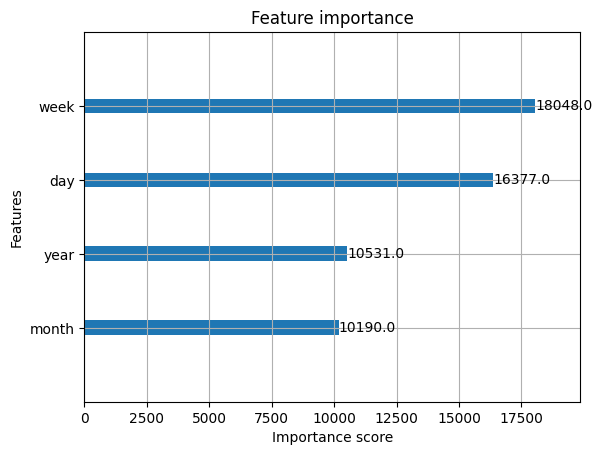

In [6]:
plot_importance(model)
plt.show()

#### Проверка результатов модели

In [7]:
# Загрузка модели
model = joblib.load("xgboost_model.pkl")

print("Столбцы в test_data до обработки:", test_data.columns)

# Проверяем, есть ли 'Price' в данных
if 'Price' in test_data.columns:
    X_test = test_data.drop(columns=["Price"]).copy()  # Убираем 'Price'
else:
    raise KeyError("Столбец 'Price' отсутствует в данных.")

# ❗ Убираем 'recommended_weeks', если он уже есть
X_test = X_test.drop(columns=["recommended_weeks"], errors="ignore")

# Проверяем соответствие признаков
expected_features = model.feature_names_in_  # Получаем признаки, с которыми обучалась модель
X_test = X_test[expected_features]  # Оставляем только нужные столбцы

# Прогнозирование
test_predictions = model.predict(X_test)

# Добавляем прогнозы в исходные данные
test_data["predicted_price"] = test_predictions

print("Данные с прогнозами:")
print(test_data.head())

# Функция для рекомендации количества недель закупки
def recommend_purchase_weeks(predicted_price, current_price):
    return 6 if predicted_price > current_price else 1  # 6 недель или 1 неделя

# Проверяем наличие 'Price' перед расчетами
if 'Price' in test_data.columns:
    test_data["recommended_weeks"] = test_data.apply(
        lambda row: recommend_purchase_weeks(row["predicted_price"], row["Price"]), axis=1
    )
else:
    raise KeyError("Столбец 'Price' отсутствует в данных.")

# Сохранение результатов
test_data.to_csv("test_with_predictions.csv", index=False)
print("Результаты сохранены в файл 'test_with_predictions.csv'.")


Столбцы в test_data до обработки: Index(['Price', 'year', 'month', 'day', 'dayofweek', 'week',
       'predicted_price'],
      dtype='object')
Данные с прогнозами:
   Price  year  month  day  dayofweek  week  predicted_price
0  46000  2022      9    5          0    36     33245.937500
1  46000  2022      9   12          0    37     32954.933594
2  46000  2022      9   19          0    38     32351.648438
3  45500  2022      9   26          0    39     32560.939453
4  45500  2022     10    3          0    40     32108.333984
Результаты сохранены в файл 'test_with_predictions.csv'.


#### Проверка ошибок модели

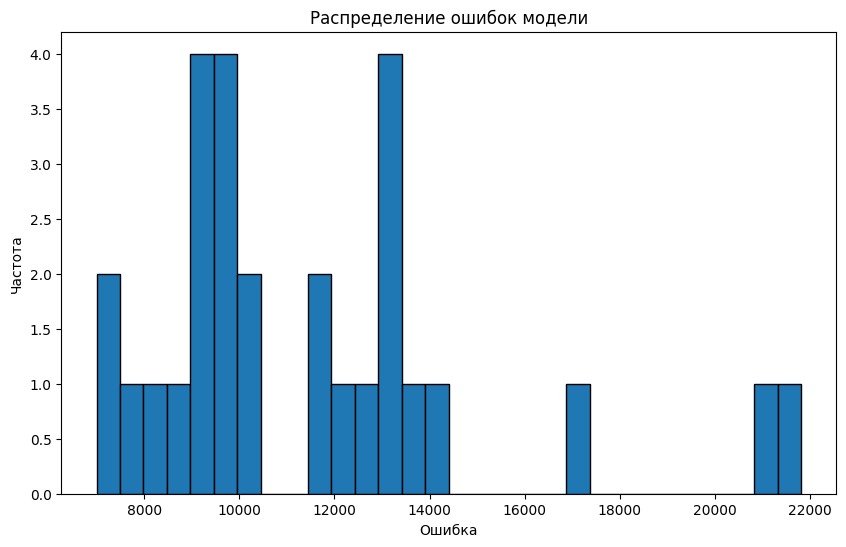

In [8]:
# Ошибки модели
errors = y_test - y_pred

# Гистограмма ошибок
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, edgecolor='black')
plt.title("Распределение ошибок модели")
plt.xlabel("Ошибка")
plt.ylabel("Частота")
plt.show()

#### Визуализация данных для обучения

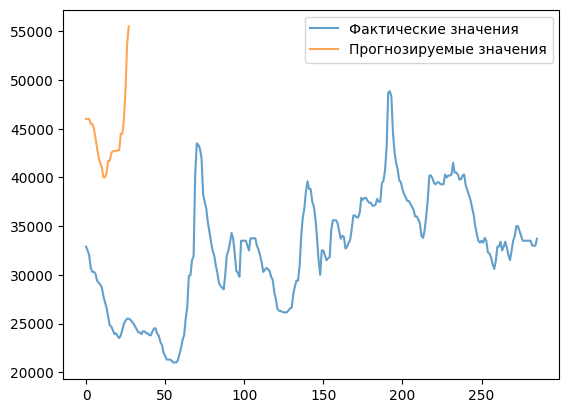

In [9]:
plt.plot(y_train, label="Фактические значения", alpha=0.7)
plt.plot(y_test, label="Прогнозируемые значения", alpha=0.7)
plt.legend()
plt.show()

#### Вычисление ошибок на графике

In [10]:
# Вычисляем ошибки
errors = y_test - y_pred

# Визуализация ошибок
plt.figure(figsize=(10, 6))
plt.plot(test_data["dt"], errors, label="Ошибки")
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Дата")
plt.ylabel("Ошибка")
plt.title("График ошибок")
plt.legend()
plt.show()

KeyError: 'dt'

<Figure size 1000x600 with 0 Axes>

#### Проверка данных после обработки

In [ ]:
# Загружаем модель
model = joblib.load("xgboost_model.pkl")

# Проверяем типы данных
print("Типы данных X перед обработкой:\n", X.dtypes)

# Если есть 'dt', создаем числовые признаки и удаляем его
if 'dt' in X.columns:
    X["year"] = X["dt"].dt.year
    X["month"] = X["dt"].dt.month
    X["day"] = X["dt"].dt.day
    X["dayofweek"] = X["dt"].dt.dayofweek
    X["week"] = X["dt"].dt.isocalendar().week.astype(int)  # Приводим к int
    X = X.drop(columns=["dt"])  # Удаляем dt, так как XGBoost не поддерживает datetime

# Проверяем типы данных после обработки
print("Типы данных X после обработки:\n", X.dtypes)

# Кросс-валидация для временных рядов
tscv = TimeSeriesSplit(n_splits=2)
mae_scores = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Прогнозирование с загруженной моделью
    y_pred = model.predict(X_test)
    
    # Оценка ошибки
    mae_scores.append(mean_absolute_error(y_test, y_pred))

print(f"Средний MAE по кросс-валидации: {np.mean(mae_scores)}")


Типы данных X перед обработкой:
 dt           datetime64[ns]
year                  int32
month                 int32
day                   int32
dayofweek             int32
week                 UInt32
dtype: object
Типы данных X после обработки:
 year         int32
month        int32
day          int32
dayofweek    int32
week         int64
dtype: object
Средний MAE по кросс-валидации: 499.8576054393797


#### Проверка работоспособности модели

In [ ]:
# Загружаем модель
model = joblib.load("xgboost_model.pkl")

# Количество недель для предсказания
N = 5

# Создаем столбец actual_price_after_N_weeks (цена через N недель)
test_data["actual_price_after_N_weeks"] = test_data["Price"].shift(-N)

# Удаляем строки, где нет будущей цены (чтобы не было NaN в target)
test_data = test_data.dropna(subset=["actual_price_after_N_weeks"])

# Проверяем, есть ли 'dt', и создаем числовые признаки из даты
if 'dt' in test_data.columns:
    test_data["year"] = test_data["dt"].dt.year
    test_data["month"] = test_data["dt"].dt.month
    test_data["day"] = test_data["dt"].dt.day
    test_data["dayofweek"] = test_data["dt"].dt.dayofweek
    test_data["week"] = test_data["dt"].dt.isocalendar().week.astype(int)
    test_data = test_data.drop(columns=["dt"])  # Удаляем dt

# Создаем копию test_data, но без целевой переменной
X_test = test_data.drop(columns=["Price", "actual_price_after_N_weeks"], errors="ignore")

# Оставляем только те признаки, которые использовались при обучении модели
X_test = X_test[model.feature_names_in_]  # Берем только обученные признаки

# Прогноз будущей цены через N недель
test_data["predicted_price_after_N_weeks"] = model.predict(X_test)

# Рекомендация (покупать на 6 недель, если цена растет, иначе на 1 неделю)
test_data["recommended_weeks"] = test_data.apply(
    lambda row: 6 if row["predicted_price_after_N_weeks"] > row["Price"] else 1, axis=1
)

# Фактическое изменение цены через N недель
test_data["price_change"] = test_data["actual_price_after_N_weeks"] - test_data["Price"]

# Оценка правильности рекомендаций
test_data["recommendation_correct"] = test_data.apply(
    lambda row: (row["price_change"] > 0 and row["recommended_weeks"] > 1) or
                (row["price_change"] <= 0 and row["recommended_weeks"] == 1),
    axis=1
)

# Доля правильных рекомендаций
accuracy = test_data["recommendation_correct"].mean()
print(f"Доля правильных рекомендаций: {accuracy * 100:.2f}%")


Доля правильных рекомендаций: 82.61%


C:\Users\Виктор\AppData\Local\Temp\ipykernel_20440\3708699500.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["actual_price_after_N_weeks"] = test_data["Price"].shift(-N)


<Axes: xlabel='dt', ylabel='Price'>

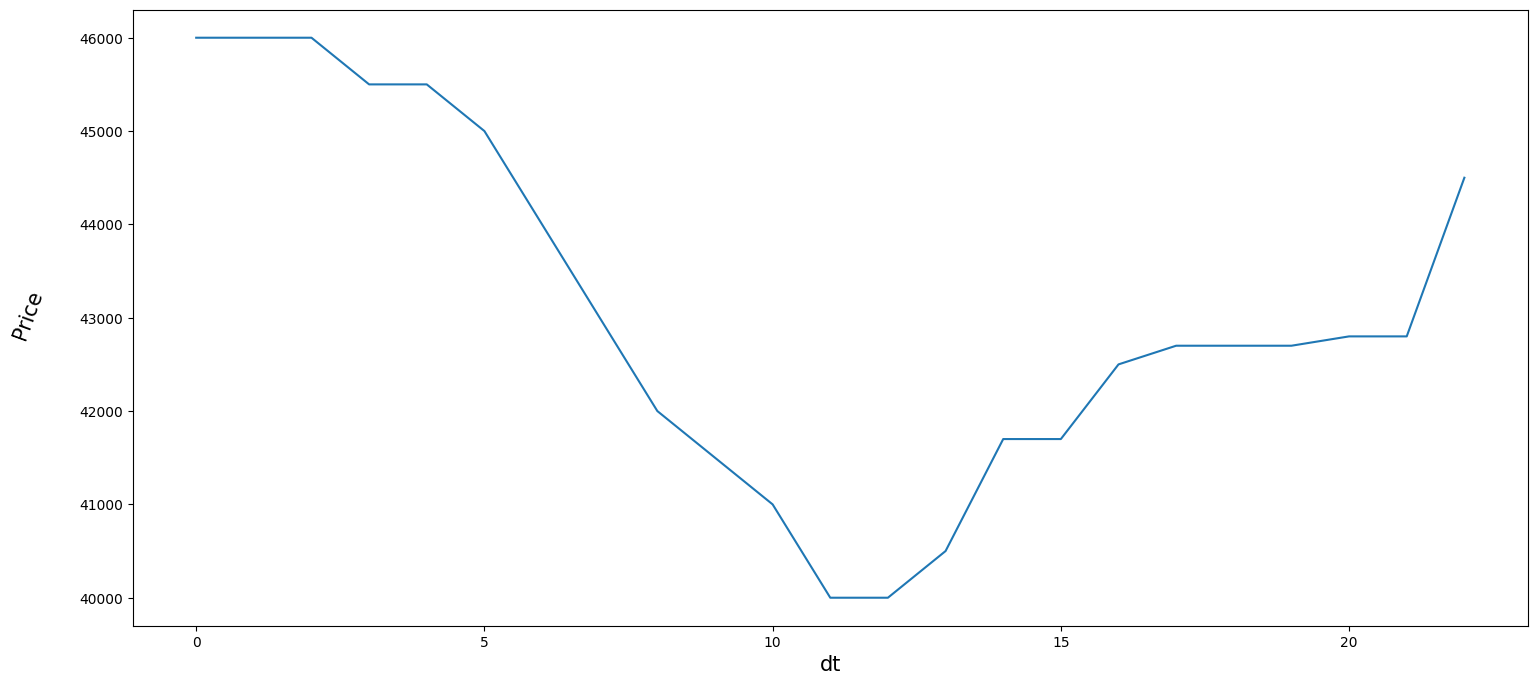

In [ ]:
plt.figure(figsize=(18, 8))
plt.xlabel('dt', fontsize=15)
plt.ylabel('Price', rotation=70, labelpad=30, fontsize=15)
test_data["Price"].plot()